In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Average number of cortical electrodes per probe (extracted from 569069, 569072, 569073, 571619). This estimate is used in case a probe does not have brain region labels.

In [7]:
probe_ctx_chs = {
    'probeB': 100,
    'probeC': 80,
    'probeF': 200
}

# Combined EEG/LFP plots with PCI and PCs

### Load experiment instance and data

In [8]:
dfolder = r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1'
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

In [10]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find('mouse')+18]
print(exp_tag)

estim1


In [11]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()

## Get bad_ch_list from metadata ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)

[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 19]


Load stimulus log and speed

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good
0,biphasic,70,0.0004,326.80900,326.80940,0,True
1,biphasic,40,0.0004,330.34202,330.34242,0,True
2,biphasic,70,0.0004,334.40364,334.40404,0,True
3,biphasic,90,0.0004,338.78593,338.78633,0,True
4,biphasic,90,0.0004,342.95554,342.95594,0,True


In [13]:
run_signal, run_timestamps = exp.load_running()

Load probe info

In [14]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [15]:
probe_order = ['probeF', 'probeB', 'probeC']

In [16]:
probe_info = {}
probe_unit_data = {}
probe_LFP_data = {}
for probei in probe_list:
    probe_info[probei] = {}
    probe_unit_data[probei] = {}
    probe_LFP_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vert pos of each electrode (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels
    print('{} brain surface channel: {:d}'.format(probei, surface_ch))

    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
    probe_info[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Get saline chs for re-ref ##
    if surface_ch + 20 > 384:
        probe_info[probei]['saline_chs'] = np.arange(383, 378, -1)
    else:
        probe_info[probei]['saline_chs'] = np.arange(surface_ch + 15, surface_ch + 20)
    if 'area_ch' in data.keys():
        probe_info[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_info[probei]['ch_CCF_coords'] = np.array(data['ccf_coord_ch'])
        ## determine cortical chs ##
        ctx_chs = []
        for chi in npx_chs:
            if probe_info[probei]['ch_areas'][chi] != 'null':
                if 315 in str_tree.get_structures_by_acronym([probe_info[probei]['ch_areas'][chi]])[0]['structure_id_path']:
                    ctx_chs.append(chi)
        probe_info[probei]['ctx_chs'] = np.array(ctx_chs)
        probe_info[probei]['white_matter_chs'] = np.arange(
            np.min(probe_info[probei]['ctx_chs']) - 2, np.min(probe_info[probei]['ctx_chs'])
        )
        print(' {:d} cortical chs'.format(len(ctx_chs)))
    else:
        print(' .json file does not have area assignments. Using estimate.')
        possible_ctx_chs = np.arange(surface_ch - probe_ctx_chs[probei], surface_ch)
        probe_info[probei]['ctx_chs'] = possible_ctx_chs[np.isin(possible_ctx_chs, npx_chs)]
        print(' {:d} cortical chs estimated'.format(len(probe_info[probei]['ctx_chs'])))
        
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    probe_unit_data[probei]['units'] = select_units[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['peak_chs'] = peak_chs[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        probe_unit_data[probei]['unit_area'] = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        areas_assigned = True
        ## determine cortical units ##
        ctx_units = []
        ctx_areas = []
        for uniti, areai in zip(probe_unit_data[probei]['units'], probe_unit_data[probei]['unit_area']):
            if areai != 'null':
                if 315 in str_tree.get_structures_by_acronym([areai])[0]['structure_id_path']:
                    ctx_units.append(uniti)
                    ctx_areas.append(areai)
        probe_unit_data[probei]['ctx_units'] = np.array(ctx_units)
        probe_unit_data[probei]['ctx_areas'] = np.array(ctx_areas)
    else:
        print(' unit metrics file does not have area assignments.')
        areas_assigned = False
    
    ## Load spike times and cluster ids ##
#     probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
#     probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])

    ## Memmap LFP data ##
    rawmm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r')
    probe_LFP_data[probei]['LFP'] = np.reshape(
        rawmm, (int(rawmm.size/exp.ephys_params[probei]['num_chs']), exp.ephys_params[probei]['num_chs']))
    probe_LFP_data[probei]['timestamps'] = np.load(exp.ephys_params[probei]['lfp_timestamps'])

probeB brain surface channel: 350
 .json file does not have area assignments. Using estimate.
 91 cortical chs estimated
 unit count: 275
 unit metrics file does not have area assignments.
probeC brain surface channel: 358
 .json file does not have area assignments. Using estimate.
 80 cortical chs estimated
 unit count: 196
 unit metrics file does not have area assignments.
probeF brain surface channel: 130
 .json file does not have area assignments. Using estimate.
 129 cortical chs estimated
 unit count: 200
 unit metrics file does not have area assignments.


#### Load data and collect traces

Load EEG data and good chs

In [17]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

Set ERP parameters

In [18]:
before_event = 1.0 # time before event, s
after_event = 1.0 # time after event, s

## EEG params ##
apply_mask = True
apply_car = True

## LFP params ##
saline_re_ref = True
white_matter_ref = False

Set PCI paramters

In [19]:
PCI_params = {
    'baseline_window': (-0.8, -0.01), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.01, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

Get ERPs and calculate PCI

In [20]:
fullPCI = {}

## Mask estim artifact ##
if apply_mask:
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]

for st_type in stim_log.stim_type.unique():
    fullPCI[st_type] = {}
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        fullPCI[st_type][parami] = {}
        param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
        for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
            fullPCI[st_type][parami][sweepi] = {}
            
            events = get_stim_events(stim_log, st_type, parami, sweepi)
            print('{} {}, sweep {:d}: {:d} trials'.format(st_type, str(parami), sweepi, len(events)))
            ## EEG traces ##
            start = time.time()
            eeg_event_traces, eeg_event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                before_event,
                after_event,
                exp.ephys_params['EEG']['sample_rate']
            )
            ## Common average reference ##
            if apply_car:
                eeg_event_traces = eeg_event_traces - np.mean(eeg_event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

            ## Design and apply Butterworth filter ##
            filtb, filta = signal.butter(
                3, np.array([0.1, 100])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
            EEG_ERP = np.mean(signal.filtfilt(filtb, filta, eeg_event_traces, axis=0), axis=2)
            
            ## PCI for EEG ERPs ##
            fullPCI[st_type][parami][sweepi]['EEG'] = calc_PCIst(
                EEG_ERP[:, GOOD_CHS].T, eeg_event_ts, full_return=True, **PCI_params
            )
            end = time.time()
            print(' EEG PCI time = {:.2f} min'.format((end-start)/60))
        
            ## LFP traces ##
            LFPcalctime = []
            for probei in probe_order:
                start = time.time()
                lfp_event_traces, lfp_event_ts = get_evoked_traces(
                    probe_LFP_data[probei]['LFP'],
                    probe_LFP_data[probei]['timestamps'],
                    events,
                    before_event,
                    after_event,
                    exp.ephys_params[probei]['lfp_sample_rate']
                )
                ## Convert to bits and baseline subtraction ##
                lfp_event_traces = ((lfp_event_traces - np.mean(lfp_event_traces[lfp_event_ts < 0.005, :, :], axis=0)) *
                                    exp.ephys_params[probei]['bit_volts'])
                ## Saline re-ref ##
                if saline_re_ref:
                    lfp_event_traces = (
                        lfp_event_traces -
                        np.mean(lfp_event_traces[:, probe_info[probei]['saline_chs'], :], axis=1)[:, None, :]
                    )
                ## White matter re-ref ##
                if white_matter_ref:
                    lfp_event_traces = (
                        lfp_event_traces -
                        np.mean(lfp_event_traces[:, probe_info[probei]['white_matter_chs'], :], axis=1)[:, None, :]
                    )

                filtb, filta = signal.butter(
                    3, np.array([0.1, 100])/(exp.ephys_params[probei]['lfp_sample_rate']/2), btype='bandpass')
                LFP_ERP = np.mean(signal.filtfilt(filtb, filta, lfp_event_traces, axis=0), axis=2)
                ## PCI for EEG ERPs ##
                fullPCI[st_type][parami][sweepi][probei] = calc_PCIst(
                    LFP_ERP[:, probe_info[probei]['ctx_chs']].T, lfp_event_ts, full_return=True, **PCI_params
                )
                end = time.time()
                LFPcalctime.append((end-start)/60)
            print(' LFP PCI time = {:.2f} min'.format(np.mean(LFPcalctime)))

biphasic 40, sweep 0: 120 trials
 EEG PCI time = 0.51 min
No components --> PCIst=0
 LFP PCI time = 0.93 min
biphasic 40, sweep 1: 120 trials
 EEG PCI time = 0.25 min
No components --> PCIst=0
 LFP PCI time = 0.83 min
biphasic 70, sweep 0: 119 trials
 EEG PCI time = 0.46 min
 LFP PCI time = 1.00 min
biphasic 70, sweep 1: 120 trials
 EEG PCI time = 0.46 min
 LFP PCI time = 1.11 min
biphasic 90, sweep 0: 120 trials
 EEG PCI time = 0.70 min
 LFP PCI time = 1.12 min
biphasic 90, sweep 1: 120 trials
 EEG PCI time = 0.47 min
 LFP PCI time = 1.22 min


Plot ERPs with PCs

<IPython.core.display.Javascript object>


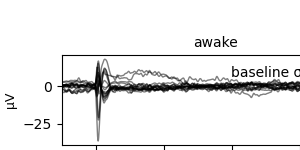

<IPython.core.display.Javascript object>


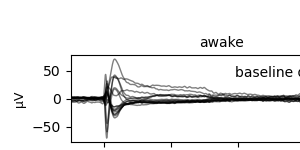

<IPython.core.display.Javascript object>


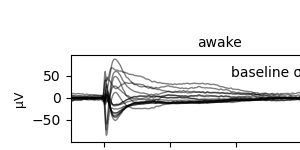

In [21]:
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
comp_states = [
    {0: 'awake', 1: 'anesthestized'},
]

plwin = [-0.1, 0.8]
PCcolors = [cm.tab10(x) for x in np.linspace(0, 1, 10)]

for paramii in fullPCI[stim_type].keys():
    for compi in comp_states:

        fig, axs = plt.subplots(8, len(compi.keys()), figsize=(10,9), sharex=True, constrained_layout=True)
        for coli, (sweepi, statei) in enumerate(compi.items()):
            for rowi, (datatype, datai) in enumerate(fullPCI[stim_type][paramii][sweepi].items()):
                timex = datai['times']
                pinds = np.squeeze(np.argwhere((timex >= plwin[0]) & (timex <= plwin[1])))

                ## evoked response ##
                traces = datai['signal_evk'].T
                ## get baseline std ##
                binds = np.squeeze(np.argwhere((timex >= -0.8) & (timex < -0.01)))
                blstd = np.mean(np.std(traces[binds, :], axis=0))
                if 'probe' in datatype:
                    axs[rowi*2, coli].plot(timex[pinds], traces[pinds, :], color='k', linewidth=0.6, alpha=0.2)
                else:
                    axs[rowi*2, coli].plot(timex[pinds], traces[pinds, :], color='k', linewidth=1, alpha=0.5)
                axs[rowi*2, coli].text(
                    0.95, 0.8, ('baseline \u03C3 = {:.2f}'.format(blstd)),
                    horizontalalignment='right', verticalalignment='center', transform=axs[rowi*2, coli].transAxes
                )
                if coli > 0:
                    axs[rowi*2, coli].sharey(axs[rowi*2, 0])
                else:
                    axs[rowi*2, coli].set_ylabel('\u03bcV', fontsize=9)
                if rowi == 0:
                    axs[rowi*2, coli].set_title(statei)

                ## plot PCs as z-score ##
                PCs = datai['signal_svd'].T
                if PCs.size == 0:
                    axs[rowi*2+1, coli].text(
                        0.5, 0.5, ('No components --> PCIst = {:.2f}'.format(datai['PCI'])),
                        horizontalalignment='center', verticalalignment='center', transform=axs[rowi*2+1, coli].transAxes
                    )
                    axs[rowi*2+1, coli].axis('off')
                else:
                    ## PC z-score ##
                    PCz = (PCs - np.mean(PCs[binds, :], axis=0)) / np.std(PCs[binds, :], axis=0)
                    for iPC in range(PCz.shape[1]):
                        axs[rowi*2+1, coli].plot(
                            timex[pinds], PCz[pinds, iPC], color=PCcolors[iPC], linewidth=1,
                            label='\u0394NST={:.2f}'.format(datai['dNST'][iPC])
                        )
                    axs[rowi*2+1, coli].legend(
                        bbox_to_anchor=(1, 1.1), loc='upper left', title='PCIst = {:.2f}'.format(datai['PCI']), fontsize=9
                    )
                    axs[rowi*2+1, coli].sharey(axs[1, 0])
                    if coli == 0:
                        axs[rowi*2+1, coli].set_ylabel('z-score', fontsize=9)

        axs[0,0].set_xlim(plwin)
        plt.suptitle('{}, {} {}'.format(exp.mouse, stim_type, str(paramii)))

        ## Save ##
        figname = 'UW_EEG_LFP_PCI_{}_{}_{}_{}.png'.format(
            exp_tag, str(paramii), list(compi.values())[0], list(compi.values())[1])
#         fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

Plot one probe to check traces

<IPython.core.display.Javascript object>


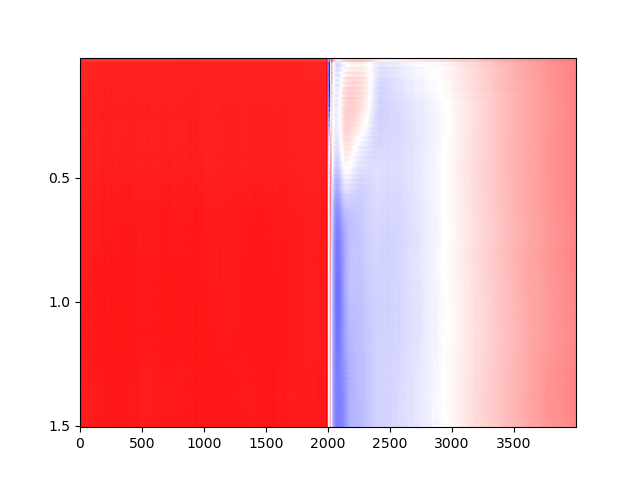

In [22]:
pl_probe = 'probeF'
pl_sweep = 0
stim_amp = 90

fig, ax = plt.subplots()

ax.imshow(
    fullPCI[stim_type][stim_amp][pl_sweep][pl_probe]['signal_evk'],
    cmap='bwr',
    interpolation='none',
    aspect='auto',
    origin='lower',
)
if 'ch_areas' in probe_info[pl_probe].keys():
    ## get area labels ##
    area_boundaries = []
    area_labels = []
    last_area = ''
    for ai, area in enumerate(probe_info[pl_probe]['ch_areas'][probe_info[pl_probe]['ctx_chs']]):
        if area != last_area:
            area_boundaries.append(ai)
            area_labels.append(area)
            last_area = area
    area_boundaries.append(ai)
    label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
    ax.set_yticks(area_boundaries)
    ax.set_yticklabels('')
    ax.set_yticks(label_locs, minor=True)
    ax.set_yticklabels(area_labels, minor=True, fontsize=8)
    ax.tick_params(which='minor', length=0)
else:
    ch_depths = probe_info[pl_probe]['ch_depths'][probe_info[pl_probe]['ctx_chs']]
    ax.set_yticks(np.arange(0, len(probe_info[pl_probe]['ctx_chs']), 50))
    ax.set_yticklabels(ch_depths[np.arange(0, len(probe_info[pl_probe]['ctx_chs']), 50)]/1000)
#     ax.annotate(
#         regions[pl_probe],
#         xy=(-0.12, 0.5),
#         xycoords='axes fraction',
#         horizontalalignment='center',
#         verticalalignment='center',
#         rotation='vertical',
#         fontsize=12
#     )